In [1]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'

In [31]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
sys.path.append(f'{ROOT_DIR}/code/wasserstein')
import WassersteinOTCost as wot
import importlib
importlib.reload(wot)
from torch.utils.data import Dataset
import pickle

## Load data

In [46]:
def load_data(dataset, cost):
    if dataset == 'synthetic':
        d1 = pd.read_csv(f'{ROOT_DIR}/data/synthetic/opposite_data_1_{cost}.csv',sep = ' ', names = [i for i in range(13)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/synthetic/opposite_data_2_{cost}.csv', sep = ' ', names = [i for i in range(13)])
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values
    
    elif dataset == 'credit':
        d1 = pd.read_csv(f'{ROOT_DIR}/data/credit/data_1_{cost}.csv',sep = ' ', names = [i for i in range(29)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/credit/data_2_{cost}.csv', sep = ' ', names = [i for i in range(29)])
        d1 = d1.sample(n=500)
        d2 = d2.sample(n=500)
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values
    
    elif dataset == 'weather':
        d1 = pd.read_csv(f'{ROOT_DIR}/data/weather/data_1_{cost}.csv',sep = ' ', names = [i for i in range(124)])
        d2 = pd.read_csv(f'{ROOT_DIR}/data/weather/data_2_{cost}.csv', sep = ' ', names = [i for i in range(124)])
        d1 = d1.sample(n=500)
        d2 = d2.sample(n=500)
        X1, y1 = d1.iloc[:,:-1].values, d1.iloc[:,-1].values
        X2, y2 = d2.iloc[:,:-1].values, d2.iloc[:,-1].values

    elif dataset == 'EMNIST':
        d1 = np.load(f'{ROOT_DIR}/data/EMNIST/data_1_{cost}.npz')
        d2 = np.load(f'{ROOT_DIR}/data/EMNIST/data_2_{cost}.npz')

        X1, y1 = d1['data'], d1['labels']
        idx = np.random.choice(np.arange(X1.shape[0]), 500, replace=False)
        X1, y1 = X1[idx], y1[idx]
        X1 = X1.reshape(28*28,-1)

        X2, y2 = d2['data'], d2['labels']
        idx = np.random.choice(np.arange(X2.shape[0]), 500, replace=False)
        X2, y2 = X2[idx], y2[idx]
        X2 = X2.reshape(28*28,-1)

    elif dataset == 'CIFAR':
        X1, X2, y1, y2 = load_cifar_embeddings(cost)

    elif dataset == 'IXITiny':
        X1 = load_data_ixitiny(cost[0])
        X2 = load_data_ixitiny(cost[1])
        return {"1":X1, "2":X2}
        


    return {"1":X1, "2":X2}, {"1":y1, "2":y2}

def load_data_ixitiny(site):
    files = os.listdir(f'{ROOT_DIR}/data/IXITiny/embedding')
    files_site = [file for file in files if site in file]
    embeddings = []
    for file in files_site:
        emb = np.load(f'{ROOT_DIR}/data/IXITiny/embedding/{file}')
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    return embeddings

### CIAFR ONLY AS EMBEDDINGS

In [4]:
class EmbeddedImagesDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, embedding, label, coarse_label = self.data[idx]
        return image, embedding, label, coarse_label

In [5]:
def extract_by_labels(dataset, target_labels, label_type = 'fine'):
    extracted_data = []
    for image, embedding, fine_label, coarse_label in dataset:
        if label_type == 'fine':
            label = fine_label
        else:
            label = coarse_label
        if label in target_labels:
            extracted_data.append((image, embedding, fine_label, coarse_label))
    return EmbeddedImagesDataset(extracted_data)

def get_datasets(dataset, labels_extract, label_type = 'fine'):
    d1 = extract_by_labels(dataset, labels_extract[0], label_type)
    d2 = extract_by_labels(dataset, labels_extract[1], label_type)
    return d1, d2

def sampler(dataset, num_samples):
    indices = random.sample(range(len(dataset)), num_samples)
    sampled_data = [dataset[i] for i in indices]
    embs = np.array([entry[1] for entry in sampled_data])
    label = np.array([entry[2] for entry in sampled_data])
    return embs, label

def load_cifar_embeddings(cost):
    labels = {0.03: [[x for x in range(10)], [x for x in range(10)]],
            0.1: [[11,98,29,1,73, 78, 49, 97, 51, 55], [11,98,29,1,73, 78, 49, 42, 83, 72]],
            0.2: [[11,50,78,1,92, 78, 49, 97], [98, 36, 29, 73, 82, 78, 49, 42]],
            0.3: [[11,50,78,8,92], [17, 36, 29, 73, 82]],
            0.4: [[15,12], [19,1]]}

    labels_extract = labels[cost]
    with open(f'{ROOT_DIR}/data/CIFAR/cifar_{1000}_emb.pkl', 'rb') as f:
        data= pickle.load(f)
    d1, d2 = get_datasets(data, labels_extract)
    num_samples = 500
    X1, y1 =  sampler(d1, num_samples)
    X2, y2 =  sampler(d2, num_samples)
    return X1, X2, y1, y2


## Load results

In [71]:
def load_model_results(dataset, costs, wasserstein):
    if dataset == 'synthetic':
        results = pd.read_csv(f'{ROOT_DIR}/results/synthetic/REV_auc_0-0.5.csv')
    
    elif dataset == 'credit':
        results = pd.read_csv(f'{ROOT_DIR}/results/credit/REV_auprc_0.1-0.4.csv')
    
    elif dataset == 'weather':
        results = pd.read_csv(f'{ROOT_DIR}/results/weather/REV_r2_0.1-0.4.csv')

    elif dataset == 'EMNIST':
        results = pd.read_csv(f'{ROOT_DIR}/results/EMNIST/REV_acc_0.07-0.4.csv')

    elif dataset == 'CIFAR':
        results = pd.read_csv(f'{ROOT_DIR}/results/CIFAR/REV_acc_0.03-0.4.csv')

    elif dataset == 'IXITiny':
        results = pd.read_csv(f'{ROOT_DIR}/results/IXITiny/REV_dice_0.03-0.28.csv')

    #Change df from our cost to wasserstein
    mapping_dict = {costs[i]: wasserstein[i] for i in range(len(costs))}
    results['cost'] = results['cost'].replace(mapping_dict)
        
    return results


In [76]:
def grapher(dataset, df, score, path, save = False):
    if dataset == 'IXITiny':
        df_change = 100 * (df[['single']].values - df[['joint', 'transfer', 'federated']]) / df[['single']].values
    else:
        df_change = 100 * (df[['joint', 'transfer', 'federated']] - df[['single']].values) / df[['single']].values
    df_change['cost'] = df['cost']
    sns.lineplot( x= df_change['cost'], y =df_change['joint'], alpha = 0.8, marker = 'o', label = 'Joint')
    sns.lineplot( x= df_change['cost'], y =df_change['transfer'], alpha = 0.8, marker = 'o', label = 'Transfer')
    sns.lineplot( x= df_change['cost'], y =df_change['federated'], alpha = 0.8, marker = 'o', label = 'Federated')
    plt.axhline(y=0, color='black', linestyle = '--', alpha = 0.5, label = 'Baseline')
    plt.xlabel('Wasserstein distance', fontsize = 14)
    plt.ylabel(f'% Change in {score}', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    if save == True:
        plt.savefig(f'{path}/Wasserstein_{dataset}_{score}_change.pdf')
    plt.show()

## Synthetic dataset

In [91]:
importlib.reload(wot)
dataset = 'synthetic'
costs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results_synthetic = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    synthetic_wot = wot.OTCost(dataset, data, label)
    results_synthetic.append(synthetic_wot.calculate_ot_cost())


cost: 8.6931057674
cost: 15.8408769808
cost: 27.3735341420
cost: 34.1923895158
cost: 44.2358276777
cost: 55.4716835044


In [92]:
df = pd.DataFrame([costs, results_synthetic]).T
df.columns = ['Ours', 'Wsserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

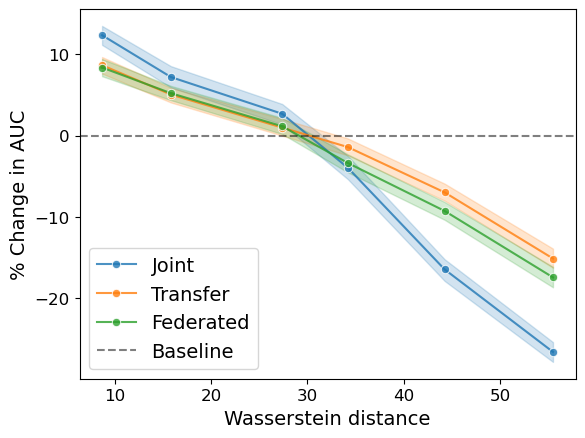

In [93]:
score = 'AUC'
path = f'{ROOT_DIR}/results/wasserstein'
results = load_model_results(dataset, costs, results_synthetic)
grapher(dataset, results, score, path, save = True)

## Credit dataset

In [84]:
importlib.reload(wot)
costs = [0.1, 0.2, 0.3, 0.4]
dataset = 'credit'
results_credit = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    credit_wot = wot.OTCost(dataset, data, label)
    results_credit.append(credit_wot.calculate_ot_cost())


cost: 51.6307371178
cost: 90.4016728354
cost: 1631.9569990698
cost: 3470.8658437842


In [85]:
df = pd.DataFrame([costs, results_credit]).T
df.columns = ['Ours', 'Wsserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

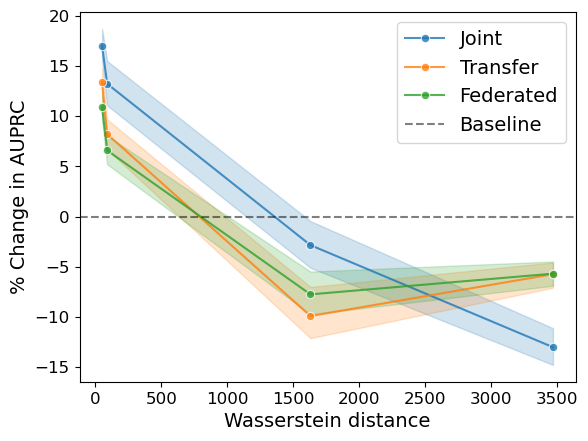

In [86]:
score = 'AUPRC'
path = f'{ROOT_DIR}/results/wasserstein/'
results = load_model_results(dataset, costs, results_credit)
grapher(dataset, results, score, path, save = True)

## Weather dataset

In [87]:
importlib.reload(wot)
costs = [0.1, 0.2, 0.3, 0.4]
dataset = 'weather'
results_weather = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    weather_wot = wot.OTCost(dataset, data, label)
    results_weather.append(weather_wot.calculate_ot_cost())

cost: 82.2159873384
cost: 126.7405041500
cost: 206.6936510036
cost: 710.3587447203


In [88]:
df = pd.DataFrame([costs, results_weather]).T
df.columns = ['Ours', 'Wsserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

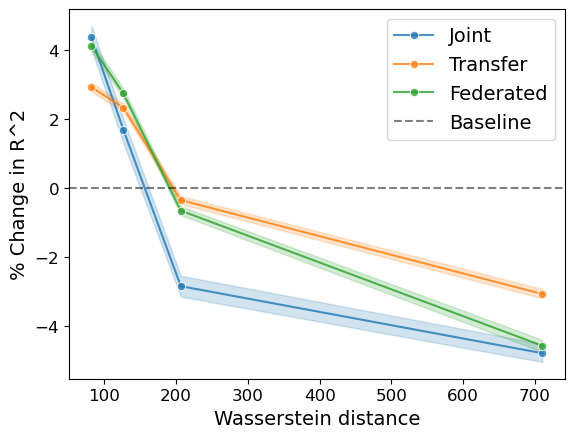

In [89]:
score = 'R^2'
path = f'{ROOT_DIR}/results/wasserstein/'
results = load_model_results(dataset, costs, results_weather)
grapher(dataset, results, score, path, save = True)

## EMNIST

In [81]:
importlib.reload(wot)
costs = [0.07, 0.1, 0.2, 0.3, 0.4]
dataset = 'EMNIST'
results_emnist = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    emnist_wot = wot.OTCost(dataset, data, label)
    results_emnist.append(emnist_wot.calculate_ot_cost())

cost: 61.5988933693
cost: 63.8202605366
cost: 65.2748535897
cost: 100.5214874270
cost: 97.9625599198


In [82]:
df = pd.DataFrame([costs, results_emnist]).T
df.columns = ['Ours', 'Wsserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

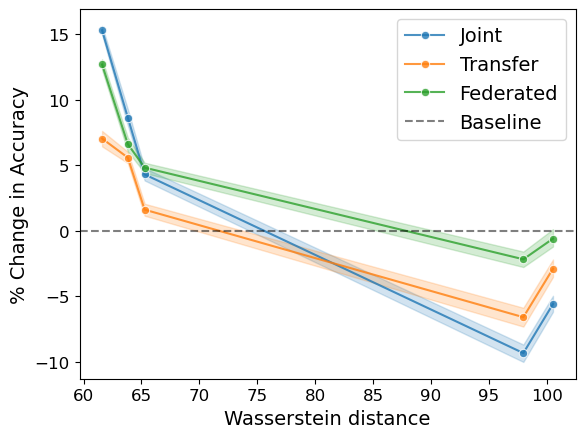

In [83]:
score = 'Accuracy'
path = f'{ROOT_DIR}/results/wasserstein/'
results = load_model_results(dataset, costs, results_emnist)
grapher(dataset, results, score, path, save = True)

## CIFAR

In [78]:
importlib.reload(wot)
costs = [0.03, 0.1, 0.2, 0.3, 0.4]
dataset = 'CIFAR'
results_cifar = []
for cost in costs:
    data, label= load_data(dataset, cost)
    ## calculate cost
    cifar_wot = wot.OTCost(dataset, data, label)
    results_synthetic.append(cifar_wot.calculate_ot_cost())

cost: 673.9953682983
cost: 4620.8142931695
cost: 14176.8630834664
cost: 24714.7778974128
cost: 31250.2753250818


In [79]:
df = pd.DataFrame([costs, results_cifar]).T
df.columns = ['Ours', 'Wsserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

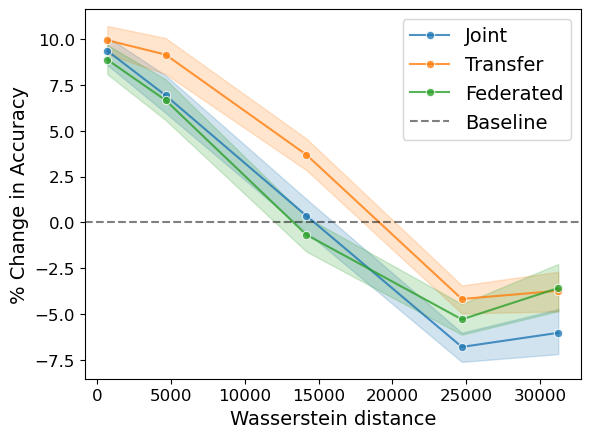

In [105]:
score = 'Accuracy'
path = f'{ROOT_DIR}/results/wasserstein'
results = load_model_results(dataset, costs, results_cifar)
grapher(dataset, results, score, path, save = True)

## IXITiny

In [68]:
importlib.reload(wot)
costs = [0.05, 0.24, 0.28]
sites =  [['HH', 'Guys'],
            ['IOP', 'Guys'],
            ['HH', 'IOP']]
dataset = 'IXITiny'
results_ixitiny = []
for site in sites:
    data = load_data(dataset, site)
    ## calculate cost
    ixitiny_wot = wot.OTCost(dataset, data, label)
    results_ixitiny.append(ixitiny_wot.calculate_ot_cost())


cost: 10106.5434328271


cost: 453072.4601498138
cost: 531762.5035413809


In [72]:
df = pd.DataFrame([costs, results_ixitiny]).T
df.columns = ['Ours', 'Wsserstein']
path = f'{ROOT_DIR}/results/wasserstein'
df.to_csv(f'{path}/Wasserstein_{dataset}.csv', index = False)

In [ ]:
score = 'Dice'
path = f'{ROOT_DIR}/results/wasserstein'
results = load_model_results(dataset, costs, results_ixitiny)
grapher(dataset, results, score, path, save = True)